<a href="https://colab.research.google.com/github/nicolosquarzoni/CNN-Vs-Scattering-transform-image-classification/blob/main/Final_Progetto_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Visual Intelligence Project Course**

The project aims to create a CNN and Scattering transform + MLP model to classify a set of images of dogs and flowers, eventually evaluating and comapring their performances


In [ ]:
#extra installations
!pip install kymatio
!pip install torchmetrics
!pip install latex

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import time
from kymatio.torch import Scattering2D
import json
from torchmetrics.classification import BinaryConfusionMatrix
from random import randint
import torchvision.transforms as T
from torchvision.utils import make_grid

#to print scattering filetrs
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
import numpy as np
from kymatio.scattering2d.filter_bank import filter_bank
from scipy.fft import fft2



Managing dataset in the folder

In [ ]:
data_dir = r'/content/drive/MyDrive/Colab Notebooks/VIdata'   

def rename(folder, t):
  count = 1
  for file_name in os.listdir(folder):
    source = folder + '/' + file_name
    destination = folder + "/img" + t + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
def delete(folder):
  for file_name in os.listdir(folder):
    if file_name != '.ipynb_checkpoints':
      source = folder + '/' + file_name
      os.remove(source)
    
#delete(data_dir + "/Train/dog")
#delete(data_dir + "/Train/flowers")
#delete(data_dir + "/Test/dog")
#delete(data_dir + "/Test/flowers")



In [ ]:
#rename(data_dir + "/Train/dog", '1')
#rename(data_dir + "/Train/flower", '2')
#rename(data_dir + "/Test/dog", '3')
#rename(data_dir + "/Test/flower", '4')

Loading Train and Test datasets from folder and applying data augmentation

In [ ]:
# Data transforms (normalization & data augmentation)
torch.manual_seed(0)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) #mean and stdv values for each channel
train_tfms = T.Compose([T.RandomCrop(128, padding=16, padding_mode='reflect'), 
                         T.RandomRotation(degrees=(-45, 45)),
                         T.ToTensor(), 
                         T.Normalize(*stats,inplace=True)])
test_tfms = T.Compose([T.ToTensor(), T.Normalize(*stats)])

In [ ]:
#Not augmented data
dataset = ImageFolder(data_dir+'/Train/', transform=ToTensor()) #special list of tuples: tensor image, number class
testset = ImageFolder(data_dir+'/Test/', transform=ToTensor())

"""#augmented data
dataset = ImageFolder(data_dir+'/Train/', train_tfms) #special list of tuples: tensor image, number class
testset = ImageFolder(data_dir+'/Test/', test_tfms)"""

"#augmented data\ndataset = ImageFolder(data_dir+'/Train/', train_tfms) #special list of tuples: tensor image, number class\ntestset = ImageFolder(data_dir+'/Test/', test_tfms)"

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);



Creating Training, Validation and Test sets mixed randomly

In [ ]:
"""#full training set
val_size = 240 #10% of Train dataset
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

"""

#20% of training set

selected_size = 480 #20% of Train dataset
discarded_size = len(dataset) - selected_size

_, selected_ds = random_split(dataset, [discarded_size, selected_size])

val_size = 48 #10% of selected dataset
train_size = selected_size - val_size

train_ds, val_ds = random_split(selected_ds, [train_size, val_size])

len(train_ds), len(val_ds)

(432, 48)

In [ ]:
batch_size = 30
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)  #every batch has two tensors: one with all the images, one with the classes

test_dl = DataLoader(testset, int(len(testset)/10), shuffle=True, num_workers=2, pin_memory=True)

  

Models definition extending ImageClassificationBase Class

In [ ]:
class ImageClassificationBasecnn(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        #print(images.shape)
        value = randint(1, 2)
        if value == 2:
          out = self(images.permute(0, 1, 3, 2))
        else:
          out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels) 
        return loss, acc                        # returns train loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc} 

    def test_step(self, batch):
        images, labels = batch
        out = self(images)         # Generate predictions  
        _, preds = torch.max(out, dim=1)
        confmat = BinaryConfusionMatrix()
        test_confmat = confmat(preds, labels)
        acc = accuracy(out, labels) # Calculate accuracy
        return {'test_confmat': test_confmat, 'test_acc': acc} 

    def validation_epoch_end(self, outputs): #outputs is a list of all validation steps in the epoch
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses and get mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # same for accuracy
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result): #prints a log at the epoch end
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
class ImageClassificationBasescat(nn.Module):
        
    def training_step(self, batch):
        images, labels = batch 
        SSx = scattering(images)
        #SSx = scattering(images)[:,:,17:]
        processed = torch.reshape(SSx, (SSx.shape[0], SSx.shape[1]*SSx.shape[2], SSx.shape[3], SSx.shape[4] ))
        out = self(processed)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels) 
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch
        SSx = scattering(images) 
        #SSx = scattering(images)[:,:,17:] #Only second second level invariants are taken from the scattering transform
        processed = torch.reshape(SSx, (SSx.shape[0], SSx.shape[1]*SSx.shape[2], SSx.shape[3], SSx.shape[4] )) #scattering transform is applied separately to all 3 image channels, 
                                                                                                               #so so all the trandform features of all channels are merged
        out = self(processed)                  # Generate predictions                   
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc} 

    def test_step(self, batch):
        images, labels = batch
        SSx = scattering(images)
        #SSx = scattering(images)[:,:,17:]
        processed = torch.reshape(SSx, (SSx.shape[0], SSx.shape[1]*SSx.shape[2], SSx.shape[3], SSx.shape[4] ))
        out = self(processed)         # Generate predictions  
        _, preds = torch.max(out, dim=1)
        confmat = BinaryConfusionMatrix()
        test_confmat = confmat(preds, labels)
        acc = accuracy(out, labels) # Calculate accuracy
        return {'test_confmat': test_confmat, 'test_acc': acc} #returns a dictionary
        
    def validation_epoch_end(self, outputs): #outputs è l'insieme di tutti i validation steps
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses and get mean value
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # same for accuracy
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result): #print relevant info at the epoch end. train loss is the avg loss in the epoch during training
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        



class CnnModel(ImageClassificationBasecnn): #fourth model with 9x9 kernels and 3 conv layers, with lower number of filters
    def __init__(self):
        '''
        Convolutional Neural Network for classification task.\n
        Parameters
        ----------
            input_channel (int): number of channel in input. (RGB=3, grayscale=1)
            num_classes (int): number of classes in the dataset.
        '''
        super().__init__()
        self.input_ch = 3
        self.num_classes = 2
        self.channels = [8,16,32]

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=self.input_ch,out_channels=self.channels[0],kernel_size=(9),stride=(1))
        self.conv2 = nn.Conv2d(in_channels=self.channels[0],out_channels=self.channels[1],kernel_size=(9),stride=(1))
        self.conv3 = nn.Conv2d(in_channels=self.channels[1],out_channels=self.channels[2],kernel_size=(5),stride=(1))
        self.drop1 = nn.Dropout1d(p=0.1)

        # Flatten layer (from ConvLayer to fully-connected)
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(3872,256)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(32,self.num_classes)
        

    def forward(self,x):
        # CNN phase
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = self.flat(x)    # flat the data to get a vector for FC layers

        # FC phase
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.softmax(self.fc3(x),dim=1)
        return x


class CnnModel0(ImageClassificationBasecnn): #third model with 9x9 kernels and 3 conv layers
    def __init__(self):
        '''
        Convolutional Neural Network for classification task.\n
        Parameters
        ----------
            input_channel (int): number of channel in input. (RGB=3, grayscale=1)
            num_classes (int): number of classes in the dataset.
        '''
        super().__init__()
        self.input_ch = 3
        self.num_classes = 2
        self.channels = [16,32,64]

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=self.input_ch,out_channels=self.channels[0],kernel_size=(9),stride=(1))
        self.conv2 = nn.Conv2d(in_channels=self.channels[0],out_channels=self.channels[1],kernel_size=(9),stride=(1))
        self.conv3 = nn.Conv2d(in_channels=self.channels[1],out_channels=self.channels[2],kernel_size=(5),stride=(1))
        self.drop1 = nn.Dropout1d(p=0.1)

        # Flatten layer (from ConvLayer to fully-connected)
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(7744,256)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(32,self.num_classes)
        

    def forward(self,x):
        # CNN phase
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = self.flat(x)    # flat the data to get a vector for FC layers

        # FC phase
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.softmax(self.fc3(x),dim=1)
        return x



class CnnModelI(ImageClassificationBasecnn): #second model with 9x9 kernels and 4 conv layers
    def __init__(self):
        '''
        Convolutional Neural Network for classification task.\n
        Parameters
        ----------
            input_channel (int): number of channel in input. (RGB=3, grayscale=1)
            num_classes (int): number of classes in the dataset.
        '''
        super().__init__()
        self.input_ch = 3
        self.num_classes = 2
        self.channels = [32,32,64,64]

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=self.input_ch,out_channels=self.channels[0],kernel_size=(9),stride=(1))
        self.conv2 = nn.Conv2d(in_channels=self.channels[0],out_channels=self.channels[1],kernel_size=(9),stride=(1))
        self.conv3 = nn.Conv2d(in_channels=self.channels[1],out_channels=self.channels[2],kernel_size=(5),stride=(1))
        self.conv4 = nn.Conv2d(in_channels=self.channels[2],out_channels=self.channels[3],kernel_size=(5),stride=(1))
        self.drop1 = nn.Dropout1d(p=0.1)

        # Flatten layer (from ConvLayer to fully-connected)
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(576,256)
        self.drop2 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(32,self.num_classes)
        

    def forward(self,x):
        # CNN phase
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))

        x = self.flat(x)    # flat the data to get a vector for FC layers

        # FC phase
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = torch.softmax(self.fc3(x),dim=1)
        return x


class CnnModelII(ImageClassificationBasecnn): #first model with 3x3 kernels
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(  #merges the layers
            nn.Conv2d(3, 32, kernel_size=3, padding=1), #from 2 to 32 channels. The output shape will be (32, ?, ?), 
                                                        #the shape of the kernel will be (3, 3, 3) and the shape of the filter will be (num_kernels (32), 
                                                        #kernel_depth, kernel_height, kernel_width): (32, 3, 3, 3)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 32 x 32 x 32  (from 128 x 128) !!!!!!!!!!!!

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 128 x 8 x 8  (from 32 x 32) !!!!!!!!!!!!

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), #flatten the 256 4x4 images in a 1d tensor
            nn.Linear(256*4*4, 1024), #fully connected layers (MLP)
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 2))
        
    def forward(self, xb):
        return self.network(xb)

class ScatteringModel(ImageClassificationBasescat):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(  #merges the layers
            nn.Flatten(), #flatten the 8x8 images in a 1d tensor. With 288 only second level invariants are taken from the scattering transform
            nn.Linear(339*8*8, 1024),  #Same MLP as CNN but with different input due to scattering transform
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 2))
            
            #first experiment with different MLP that maintains similar reduction proportions between layers
            #nn.Linear(339*8*8, 2712)
            #nn.ReLU(),
            #nn.Linear(2712, 1356),
            #nn.ReLU(),
            #nn.Linear(1356, 678),
            #nn.ReLU(),
            #nn.Linear(678, 10),
            #nn.ReLU(),
            #nn.Linear(10, 2))
           
    def forward(self, xb):
        return self.network(xb)





Models training

In [ ]:
@torch.no_grad() #decorator to not calculate the gradient and save computtion capacity
def evaluate(model, val_loader):
    model.eval() #mode to save computation capacity
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)  #mean values of acc and loss of all validation batches

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() #mode to make all the necessary computations
        train_losses = []
        train_acc = []
        for batch in train_loader: #optimize weights for each batch
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward() #gradient computation
            optimizer.step()#weights update
            optimizer.zero_grad()#gradient reset
        # Validation phase
        result = evaluate(model, val_loader) #from top, mean values of acc and loss of all validation batches 
        result['train_loss'] = torch.stack(train_losses).mean().item() #add training information to the result
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result) #store the epoch result in a list
    return history

def accuracy(outputs, labels): #from definition
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Model Testing

In [ ]:
@torch.no_grad()
def test(model, test_dl):
    model.eval() 
    outputs = [model.test_step(batch) for batch in test_dl]
    batch_confmats = [x['test_confmat'] for x in outputs]
    batch_accuracies = [x['test_acc'] for x in outputs]
    test_confmat = sum(torch.stack(batch_confmats)) #calculates the full confusion matrix from all batches
    return {'test_confmat': test_confmat , 'test_acc': torch.stack(batch_accuracies).mean().item(), 
            'test_prec': (test_confmat[0][0]/(test_confmat[0][1] + test_confmat[0][0])).item(), 
            'test_rec': (test_confmat[0][0]/(test_confmat[1][0] + test_confmat[0][0])).item()} #mean value of accuracy, precision and recall calculated from the confusion matrix 

Save and retrive history and trained models

In [ ]:
#save and retrive training and validation logs
def SaveHistory(history, path):
  with open(path, "w") as fp:
    json.dump(history, fp)

def RetriveHistory(path):
  with open(path, "r") as fp:
    return json.load(fp)

#saving and retriving trained models

def SaveModel(model, path): #exetntion file is .pt
  torch.save(model.state_dict(), path )

def RetriveModel(model, path): #input a new generated model to transfer saved parametrs
  model.load_state_dict(torch.load(path))
  return model



Plot accuracies and losses

In [ ]:
def plot_accuracies(cnnhistory, schistory):
    #extract from history all the parameters
    vcnnaccuracies = [x['val_acc'] for x in cnnhistory]
    vscaccuracies = [x['val_acc'] for x in schistory]
    trcnnaccuracies = [x['train_acc'] for x in cnnhistory]
    trscaccuracies = [x['train_acc'] for x in schistory]
    plt.plot(vcnnaccuracies, '-bx')
    plt.plot(vscaccuracies, '-rx')
    plt.plot(trcnnaccuracies, '-gx')
    plt.plot(trscaccuracies, '-yx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation acc CNN', 'Validation acc Scat', 'Training acc CNN', 'Training acc Scat'])
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(cnnhistory, schistory):
    vcnnlosses = [x['val_loss'] for x in cnnhistory]
    vsclosses = [x['val_loss'] for x in schistory]
    trcnnlosses = [x['train_loss'] for x in cnnhistory]
    trsclosses = [x['train_loss'] for x in schistory]
    plt.plot(vcnnlosses, '-bx')
    plt.plot(vsclosses, '-rx')
    plt.plot(trcnnlosses, '-gx')
    plt.plot(trsclosses, '-yx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Validation loss CNN', 'Validation loss Scat', 'Training loss CNN', 'Training loss Scat'])
    plt.title('Loss vs. No. of epochs');

       


Training CNN


In [ ]:
cnnmodel = CnnModel()

print("Pre Training ", evaluate(cnnmodel, val_dl))

#set hyperparameters
num_epochs = 70
opt_func = torch.optim.Adam #adam algortithm more efficient than SGD
lr = 0.00005

"""cnnmodel = RetriveModel(cnnmodel, data_dir+'/Models/cnnmodelIIIrot_120_0005.pt')"""
cnnhistory = fit(num_epochs, lr, cnnmodel, train_dl, val_dl, opt_func) #list of dictionaries with mean loss and accuracy from each epoch
#save the model and the history on Google Drive
SaveHistory(cnnhistory, data_dir +'/Models/20cnnhistoryIVnorot_70_0005.txt')
SaveModel(cnnmodel, data_dir +'/Models/20cnnmodelIVnorot_70_0005.pt')


Pre Training  {'val_loss': 0.6942464709281921, 'val_acc': 0.4583333134651184}
Epoch [0], train_loss: 0.6931, train_acc: 0.5069, val_loss: 0.6944, val_acc: 0.4583
Epoch [1], train_loss: 0.6927, train_acc: 0.5069, val_loss: 0.6940, val_acc: 0.4583
Epoch [2], train_loss: 0.6908, train_acc: 0.5069, val_loss: 0.6930, val_acc: 0.4583
Epoch [3], train_loss: 0.6846, train_acc: 0.5532, val_loss: 0.6884, val_acc: 0.5000
Epoch [4], train_loss: 0.6637, train_acc: 0.6181, val_loss: 0.7013, val_acc: 0.4375
Epoch [5], train_loss: 0.6584, train_acc: 0.6227, val_loss: 0.6993, val_acc: 0.5417
Epoch [6], train_loss: 0.6457, train_acc: 0.6690, val_loss: 0.6647, val_acc: 0.6667
Epoch [7], train_loss: 0.6227, train_acc: 0.6875, val_loss: 0.6512, val_acc: 0.7083
Epoch [8], train_loss: 0.6071, train_acc: 0.7292, val_loss: 0.6214, val_acc: 0.7292
Epoch [9], train_loss: 0.5817, train_acc: 0.7569, val_loss: 0.6116, val_acc: 0.7083
Epoch [10], train_loss: 0.5873, train_acc: 0.7245, val_loss: 0.5971, val_acc: 0.70

In [ ]:
SaveModel(cnnmodel, data_dir +'/Models/cnnmodelIIInorot_150_0005.pt')

Training NN using Scattering transform

In [ ]:
scattering = Scattering2D(J=4, L = 4, max_order= 2, shape=(128, 128)) #scattering transform definition. 4 scales, 4 angles and order 2. the output on 30 coloured images is 
                                                                      #torch.Size([30, 3, 113, 8, 8]), for each channel 113 8x8 ''images'', where 8x8 is 128/2^4
scmodel = ScatteringModel()

batch_size = 10
strain_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
sval_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

print("Pre Training ", evaluate(scmodel, sval_dl))

#set hyperparameters
num_epochs = 70
opt_func = torch.optim.Adam
lr = 0.00001


"""scmodel = RetriveModel(scmodel, data_dir+'/Models/scprova.pt')"""
scathistory = fit(num_epochs, lr, scmodel, strain_dl, sval_dl, opt_func) #list of dictionaries with mean loss and accuracy from each epoch
#save the model and the history on Google Drive
SaveHistory(scathistory, data_dir +'/Models/20scathistoryIIIfull_70_00001.txt')
SaveModel(scmodel, data_dir +'/Models/20scmodelIIIfull_70_00001.pt')


Pre Training  {'val_loss': 0.69587641954422, 'val_acc': 0.46666669845581055}
Epoch [0], train_loss: 0.6920, train_acc: 0.5068, val_loss: 0.6945, val_acc: 0.4667
Epoch [1], train_loss: 0.6888, train_acc: 0.5114, val_loss: 0.6912, val_acc: 0.4500
Epoch [2], train_loss: 0.6865, train_acc: 0.5773, val_loss: 0.6898, val_acc: 0.4500
Epoch [3], train_loss: 0.6813, train_acc: 0.6159, val_loss: 0.6856, val_acc: 0.5250
Epoch [4], train_loss: 0.6764, train_acc: 0.6750, val_loss: 0.6819, val_acc: 0.5833
Epoch [5], train_loss: 0.6692, train_acc: 0.7227, val_loss: 0.6770, val_acc: 0.6667
Epoch [6], train_loss: 0.6614, train_acc: 0.7432, val_loss: 0.6736, val_acc: 0.6500
Epoch [7], train_loss: 0.6519, train_acc: 0.7614, val_loss: 0.6666, val_acc: 0.6667
Epoch [8], train_loss: 0.6433, train_acc: 0.7432, val_loss: 0.6643, val_acc: 0.6500
Epoch [9], train_loss: 0.6288, train_acc: 0.7591, val_loss: 0.6514, val_acc: 0.7167
Epoch [10], train_loss: 0.6146, train_acc: 0.7841, val_loss: 0.6458, val_acc: 0.700

Models Testing

In [ ]:
#CNN

cnnmodel = CnnModel()
cnnmodel = RetriveModel(cnnmodel, data_dir +'/Models/20cnnmodelIVnorot_70_0005.pt') #change the path to load different trained models

print("Evaluation check ", evaluate(cnnmodel, val_dl))
test_result = test(cnnmodel, test_dl)
print("Confusion Matrix: \n", test_result['test_confmat'].numpy())
print("Accuracy: ", test_result['test_acc'], " Precision: ", test_result['test_prec'], " Recall: ", test_result['test_rec'] )


Evaluation check  {'val_loss': 0.547991931438446, 'val_acc': 0.75}
Confusion Matrix: 
 [[342  58]
 [ 46 354]]
Accuracy:  0.8700000047683716  Precision:  0.8550000190734863  Recall:  0.8814433217048645


In [ ]:
#Scattering + MLP
scattering = Scattering2D(J=4, L = 4, max_order= 2, shape=(128, 128)) #scattering transform definition
scmodel = ScatteringModel()
scmodel = RetriveModel(scmodel, data_dir +'/Models/scmodelII_70_0001.pt') #change the path to load different trained models

print("Evaluation check ", evaluate(scmodel, sval_dl))
sctest_result = test(scmodel, test_dl)
print("Confusion Matrix: \n", sctest_result['test_confmat'].numpy())
print("Accuracy: ", sctest_result['test_acc'], " Precision: ", sctest_result['test_prec'], " Recall: ", sctest_result['test_rec'] )


Training Plots loss


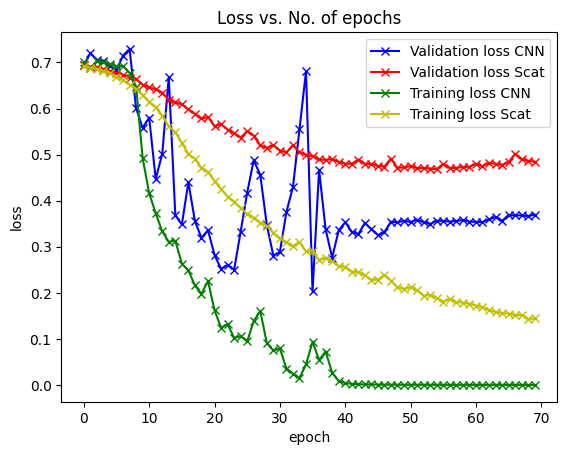

In [ ]:
plot_losses(RetriveHistory(data_dir +'/Models/20cnnhistory_70_00001.txt'), RetriveHistory(data_dir +'/Models/20scathistoryII_70_00001.txt')) #change the path to load different histories

Training Plots acccuracy

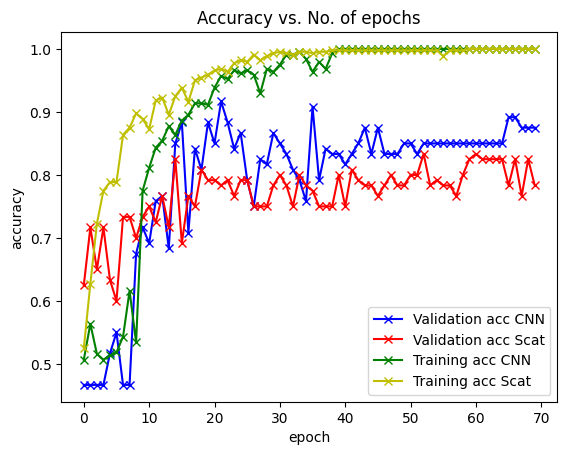

In [ ]:
plot_accuracies(RetriveHistory(data_dir +'/Models/20cnnhistory_70_00001.txt'), RetriveHistory(data_dir +'/Models/20scathistoryII_70_00001.txt')) #change the path to load different histories

CNN filters plot


In [ ]:
#coloured plots
cnnmodel = CnnModelIII()
cnnmodel = RetriveModel(cnnmodel, data_dir +'/Models/cnnmodel_90_0001.pt') #use this line to plot filters after training
plt.figure()
f, axarr = plt.subplots(4,8) #only the first layer filters (32) are plottable
for name, module in cnnmodel.named_modules(): #it could plot all the filters, the break stops it at the first
    if isinstance(module, nn.Conv2d):
        kernels = module.weight.detach().clone()
        #normalization
        kernels = kernels - kernels.min()
        kernels = kernels / kernels.max()
        #fill the subplot
        count = 0 
        for filter in kernels:
            axarr[count // 8, count % 8].imshow(filter.permute(1, 2, 0)) # change ordering since matplotlib requires images to be (H, W, C)
            axarr[count // 8, count % 8].axis('off')
            axarr[count // 8, count % 8].set_title(
                "$Filter {}$".format(count))
            count += 1
        break


Evaluation check  {'val_loss': 0.3682865500450134, 'val_acc': 0.9458333253860474}
torch.Size([8, 3, 9, 9])
torch.Size([24, 9, 9])


<Figure size 640x480 with 0 Axes>

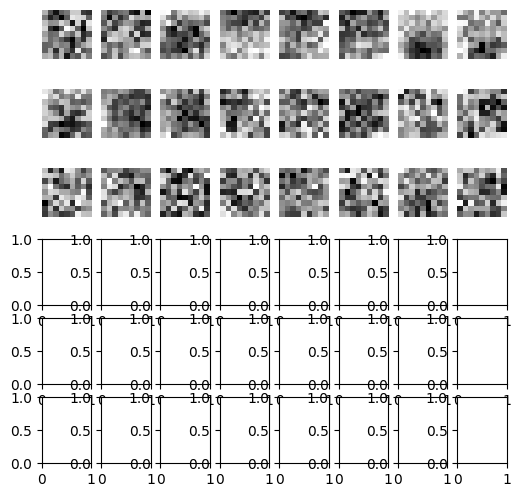

In [ ]:
#black and white plots
cnnmodel = CnnModel()
cnnmodel = RetriveModel(cnnmodel, data_dir +'/Models/cnnmodelIVrot_150_0005.pt') #use this line to plot filters after training
plt.figure()
f, axarr = plt.subplots(6,8) #only the first layer filters (32) are plottable
f.set_figheight(6)
f.set_figwidth(6)
print("Evaluation check ", evaluate(cnnmodel, val_dl))
for name, module in cnnmodel.named_modules(): #it could plot all the filters, the break stops it at the first
    if isinstance(module, nn.Conv2d):
        kernels = module.weight.detach().clone()
        #normalization
        kernels = kernels - kernels.min()
        kernels = kernels / kernels.max()
        #fill the subplot
        count = 0
        c = torch.reshape(kernels, (kernels.shape[0]*kernels.shape[1],9,9)) #reshape separating the chnnels
        for filter in c:
            axarr[count // 8, count % 8].imshow(filter, cmap = 'gray') 
            axarr[count // 8, count % 8].axis('off')
            #axarr[count // 8, count % 8].set_title(
                #"$Filteer {}$".format(count))
            count += 1
        break

Scattering Filters plot

<Figure size 640x480 with 0 Axes>

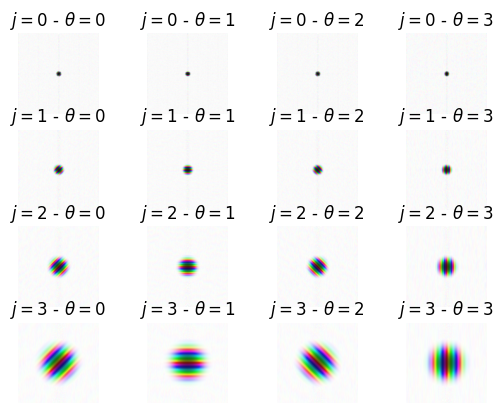

In [ ]:
#Scattering transform parameters
M = 128
J = 4
L = 4
filters_set = filter_bank(M, M, J, L=L) #extract filters as dictionary of nparrays

#build image
def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3)) #initialize the image as numpy array
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    A = (np.angle(z[idx]) + np.pi) / (2*np.pi)
    A = (A + 0.5) % 1.0
    B = 1.0/(1.0 + abs(z[idx])**0.3)
    c[idx] = [hls_to_rgb(a, b, 0.8) for a, b in zip(A, B)]
    return c

# displays each wavelet filter related to each scale and orientation
plt.figure()
f, axarr = plt.subplots(J,L) 
count = 0 
#fill the subplot with all the filters
for filter in filters_set['psi']:
    f = filter["levels"][0]
    filter_c = fft2(f)
    filter_c = np.fft.fftshift(filter_c)
    axarr[count // L, count % L].imshow(colorize(filter_c))
    axarr[count // L, count % L].axis('off')
    axarr[count // L, count % L].set_title(
        "$j = {}$ - $\\theta={}$".format(count // L, count % L))
    count += 1



Scaling function plot

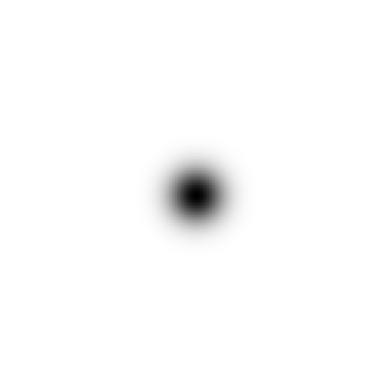

In [ ]:
# display the scaling function
plt.figure()
plt.axis('off')
plt.set_cmap('gray_r')

f = filters_set['phi']["levels"][0] #extract the scaling function

filter_c = fft2(f)
filter_c = np.fft.fftshift(filter_c)
filter_c = np.abs(filter_c)

plt.imshow(filter_c)
